In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import os
import time
import math
import random
import string
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
import numpy as np
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms

# sns.set()
%matplotlib inline

In [98]:
class NamesDataset(Dataset):
    def __init__(self, data_dir, letters: str = None):
        self.data_dir = Path(data_dir)

        self.letters = letters or string.ascii_letters + ",.;'"
        self.num_letters = len(self.letters)

        self.files = sorted(self.data_dir.glob("*.txt"))
        self.categories = []
        self.category_lines = {}
        for file in self.files:
            category = file.stem
            self.categories.append(category)
            self.category_lines[category] = self._read_lines(file)
        self.num_categories = len(self.categories)
        self.cat_lengths = [len(self.category_lines[cat]) for cat in self.categories]
        self.cum_cat_lengths = np.cumsum(self.cat_lengths)
        print("Category sizes:", {cat: cat_len for cat, cat_len in zip(self.categories, self.cat_lengths)})
        self.samples = []
        for cat, names in self.category_lines.items():
            self.samples.extend(zip(names, [self.categories.index(cat)] * len(names)))
        self.class_weights = [min(self.cat_lengths) / l for l in self.cat_lengths]
        self.sample_weights = [self.class_weights[c] for n, c in self.samples]

    def _read_lines(self, file):
        with open(file, encoding="utf8") as f:
            lines = f.read().strip().split()
            return list(map(self._unicode_to_ascii, lines))

    def _unicode_to_ascii(self, s):
        normalized = unicodedata.normalize("NFD", s)
        return "".join(filter(
            lambda c: unicodedata.category(c) != "Mn" and c in self.letters,
            normalized
        ))

    def _letter_to_index(self, letter):
        return self.letters.find(letter)

    def _line_to_tensor(self, line):
        tensor = torch.zeros(len(line), self.num_letters)
        letter_indices = list(map(self._letter_to_index, line))
        for i, letter_idx in enumerate(letter_indices):
            tensor[i][letter_idx] = 1
        return tensor

    def index_to_category(self, index):
        return self.categories[index]
    
    def sample_to_tensor(self, name, cat_idx):
        name_tensor = self._line_to_tensor(name)
        category_tensor = torch.tensor(cat_idx).long()
        return name_tensor, category_tensor

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) + idx
#         # First `i` where idx >= self.cumulative_category_lengths[i]
        cat_index = next(
            i for i, v in enumerate(self.cum_cat_lengths) if v > idx
        )
#         idx = idx - self.cum_cat_lengths[cat_index - 1] if cat_index else idx
#         category = self.categories[cat_index]
#         name = self.category_lines[category][idx]
        name, cat_idx = self.samples[idx]
        return self.sample_to_tensor(name, cat_idx)

    def decode_name_tensor(self, name_tensor):
        return "".join([self.letters[i] for i in name_tensor.argmax(1)])

    def __len__(self):
        return self.cum_cat_lengths[-1]

# NamesDataset("data/names")[2268]

In [102]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(
            self.input_size, self.hidden_size, num_layers=1,
            batch_first=True,
        )
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inp):
        print(nn.utils.rnn.pad_packed_sequence(inp)[0].shape)
        lstm_out, (hidden, cell) = self.lstm(inp)
        print(hidden.shape)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
            lstm_out,
            batch_first=True,
        )
        lstm_out = lstm_out[:, -1]
        logits = self.fc(hidden)
        return logits

In [103]:
# Utility functions
def collate_batch(batch):
    inputs = [s[0] for s in batch]
    inputs = torch.nn.utils.rnn.pack_sequence(inputs, enforce_sorted=False)
    labels = torch.stack([s[1] for s in batch])
    return inputs, labels

def unpack_tensor(packed_tensor):
    padded_tensor, lengths = torch.nn.utils.rnn.pad_packed_sequence(
        packed_tensor,
        batch_first=True,
    )
    tensors = [t[:l] for t, l in zip(padded_tensor, lengths)]
    return tensors

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [104]:
# Data
DATA_DIR = Path("data/names")
SHUFFLE = True
# Hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_HIDDEN = 128
EPOCHS = 1
SAMPLES_PER_EPOCH = 1
# Training options
CUDA = True  # Set false if not using GPU
# =======================================
# =======================================
train_dataset = NamesDataset(DATA_DIR)
sample_weights = train_dataset.sample_weights
class_weights = train_dataset.class_weights
sampler = WeightedRandomSampler(sample_weights, len(train_dataset))
train_dataloader = DataLoader(
    train_dataset,
    shuffle=SHUFFLE,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
#     sampler=sampler,
    num_workers=12,
)
print(f"Dataset contains {len(train_dataset)} samples.")
# =======================================
# =======================================
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()
rnn = RNNClassifier(train_dataset.num_letters, NUM_HIDDEN, train_dataset.num_categories)
if CUDA:
    rnn.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr=LEARNING_RATE)
rnn.train()
pbar = tqdm(
        total=len(train_dataloader),
        mininterval=0.5, maxinterval=2,
        dynamic_ncols=True, leave=False,
    )
for epoch in range(1, EPOCHS + 1):
    pbar.reset()
    pbar.desc = f"Epoch {epoch}"
    for i, (name_tensor, label) in enumerate(train_dataloader):
        if SAMPLES_PER_EPOCH and i == SAMPLES_PER_EPOCH:
            break
        if CUDA:
            name_tensor = name_tensor.cuda()
            label = label.cuda()
        optimizer.zero_grad()
        pred = rnn(name_tensor)
        pred_idx = pred.argmax(1)
        loss = loss_fn(pred, label)
        correct = torch.sum(pred_idx == label)
        pbar.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        current_loss += loss
        all_losses.append(loss.item())
        pbar.update(1)
    label_cat = train_dataset.categories[label[0]]
    pred_cat = train_dataset.categories[pred_idx[0]]
    correct = "✓" if pred_cat == label_cat else f"✗ ({label_cat})"
    unpacked_name_tensor = unpack_tensor(name_tensor)
    name = train_dataset.decode_name_tensor(unpacked_name_tensor[0])
    print(f"Name: {name} | Pred: {pred_cat} {correct}")
pbar.close()

Category sizes: {'Arabic': 2000, 'Chinese': 268, 'Czech': 520, 'Dutch': 298, 'English': 3671, 'French': 282, 'German': 730, 'Greek': 203, 'Irish': 232, 'Italian': 726, 'Japanese': 991, 'Korean': 94, 'Polish': 139, 'Portuguese': 75, 'Russian': 9480, 'Scottish': 100, 'Spanish': 307, 'Vietnamese': 73}
Dataset contains 20189 samples.


torch.Size([12, 32, 56])
torch.Size([1, 32, 128])


ValueError: Expected input batch_size (1) to match target batch_size (32).

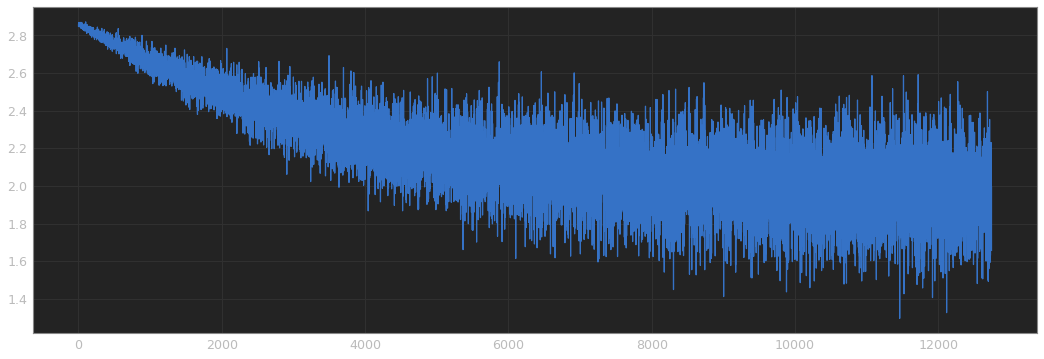

In [22]:
# plt.figure()
plt.figure(figsize=(18, 6))
sns.lineplot(list(range(len(all_losses))), all_losses)

In [ ]:
confusion = torch.zeros(NUM_CATEGORIES, NUM_CATEGORIES)
n_confusion = 10000

def evaluate(model, line_tensor):
    hidden = model.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(rnn, line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = categories.index(category)
    confusion[category_i][guess_i] += 1
